# Projekt AAI

## Pobranie danych

In [ ]:
import kaggle

# Pobieranie Iris Species dataset
kaggle.api.dataset_download_files('uciml/iris', path='./iris', unzip=True)

# Pobieranie IMDB dataset
kaggle.api.dataset_download_files('lakshmi25npathi/imdb-dataset-of-50k-movie-reviews', path='./imdb', unzip=True)

# Pobieranie Boston Housing dataset
kaggle.api.dataset_download_files('vikrishnan/boston-house-prices', path='./boston_housing', unzip=True)

# Pobieranie Chest X-Ray dataset
kaggle.api.dataset_download_files('paultimothymooney/chest-xray-pneumonia', path='./chest_xray', unzip=True)

## Implementacja wybranych architektur na prostych zbiorach danych

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

### Zbiór danych Iris Species (klasyfikacja)
1. Model drzewa decyzyjnego
2. Model k-najbliższych sąsiadów
3. Model naiwnego klasyfikatora Bayesa

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Wczytanie danych
iris_df = pd.read_csv('./iris/Iris.csv')

# Przekształcenie nazw gatunków na wartości liczbowe
le = LabelEncoder()
iris_df['Species'] = le.fit_transform(iris_df['Species'])

# Podział danych na zestaw treningowy i testowy
iris_train_data, iris_test_data, iris_train_labels, iris_test_labels = train_test_split(
    iris_df.drop(['Species', 'Id'], axis=1), iris_df['Species'], test_size=0.2, random_state=42)

# Model drzewa decyzyjnego
iris_dt = DecisionTreeClassifier()
iris_dt.fit(iris_train_data, iris_train_labels)
iris_dt_preds = iris_dt.predict(iris_test_data)
print(f"Dokładność drzewa decyzyjnego: {iris_dt.score(iris_test_data, iris_test_labels)}")

# Model k-najbliższych sąsiadów
iris_knn = KNeighborsClassifier()
iris_knn.fit(iris_train_data, iris_train_labels)
iris_knn_preds = iris_knn.predict(iris_test_data)
print(f"Dokładność k-najbliższych sąsiadów: {iris_knn.score(iris_test_data, iris_test_labels)}")

# Model naiwnego klasyfikatora Bayesa
iris_gnb = GaussianNB()
iris_gnb.fit(iris_train_data, iris_train_labels)
iris_gnb_preds = iris_gnb.predict(iris_test_data)
print(f"Dokładność naiwnego klasyfikatora Bayesa {iris_gnb.score(iris_test_data, iris_test_labels)}")

Dokładność drzewa decyzyjnego: 1.0
Dokładność k-najbliższych sąsiadów: 1.0
Dokładność naiwnego klasyfikatora Bayesa 1.0


### Zbiór danych IMDB (klasyfikacja tekstowa)
1. Model regresji logistycznej z zastosowanie TF-IDF (Term Frequency-Inverse Document Frequency) jako cech
2. Model Naive Bayes
3. Prosty model sieci neuronowej

In [24]:
import re
import nltk
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Wczytanie danych
imdb_df = pd.read_csv('./imdb/IMDB Dataset.csv')

# Wstępne przetwarzanie tekstu
stop_words = set(stopwords.words('english'))
lemmatizzer = WordNetLemmatizer()


def preprocess_test(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Usunięcie znaków specjalnych
    text = ' '.join(lemmatizzer.lemmatize(word) for word in text.split() if
                    word not in stop_words)  # lematyzacja i usunięcie stop words
    return text


imdb_df['review'] = imdb_df['review'].apply(preprocess_test)

# Przekształcenie opinii na wartości liczbowe
imdb_df['sentiment'] = imdb_df['sentiment'].map({'positive': 1, 'negative': 0})

# Podział danych na zestaw treningowy i testowy
imdb_train_data, imdb_test_data, imdb_train_labels, imdb_test_labels = train_test_split(imdb_df['review'],
                                                                                        imdb_df['sentiment'],
                                                                                        test_size=0.2, random_state=42)

# Zastosuj TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
imdb_train_data = vectorizer.fit_transform(imdb_train_data)
imdb_test_data = vectorizer.transform(imdb_test_data)

# Przekształcenie rzadkich macierzy na gęste macierze
imdb_train_data_dense = imdb_train_data.A
imdb_test_data_dense = imdb_test_data.A

# Przekształcenie etykiet na numpy arrays
imdb_train_labels = imdb_train_labels.to_numpy()
imdb_test_labels = imdb_test_labels.to_numpy()

# Model regresji logistycznej
imdb_lr = LogisticRegression()
imdb_lr.fit(imdb_train_data, imdb_train_labels)
imdb_lr_preds = imdb_lr.predict(imdb_test_data)
print("Dokładność regresji logistycznej: ", accuracy_score(imdb_test_labels, imdb_lr_preds))

# Model Naive Bayes
imdb_nb = MultinomialNB()
imdb_nb.fit(imdb_train_data, imdb_train_labels)
imdb_preds_nb = imdb_nb.predict(imdb_test_data)
print("Dokładność Naive Bayes: ", accuracy_score(imdb_test_labels, imdb_preds_nb))

# Tworzenie TensorFlow Dataset
imdb_train_dataset = tf.data.Dataset.from_tensor_slices((imdb_train_data_dense, imdb_train_labels)).batch(32)
imdb_test_dataset = tf.data.Dataset.from_tensor_slices((imdb_test_data_dense, imdb_test_labels)).batch(32)

# Model prostej sieci neuronowej
model = Sequential()
model.add(Dense(64, input_dim=imdb_train_data.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(imdb_train_dataset, epochs=4, verbose=1, validation_data=imdb_test_dataset)
scores = model.evaluate(imdb_test_dataset)
print("Dokładność prostej sieci neuronowej: ", scores[1])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gadwall/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gadwall/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dokładność regresji logistycznej:  0.8851
Dokładność Naive Bayes:  0.8526
Epoch 1/4
1250/1250 [==============================] - 2s 2ms/step - loss: 0.3654 - accuracy: 0.8412 - val_loss: 0.2689 - val_accuracy: 0.8862
Epoch 2/4
1250/1250 [==============================] - 2s 1ms/step - loss: 0.2506 - accuracy: 0.9021 - val_loss: 0.2756 - val_accuracy: 0.8848
Epoch 3/4
1250/1250 [==============================] - 2s 1ms/step - loss: 0.2119 - accuracy: 0.9229 - val_loss: 0.2875 - val_accuracy: 0.8839
Epoch 4/4
313/313 [==============================] - 0s 595us/step - loss: 0.3118 - accuracy: 0.8811
Dokładność prostej sieci neuronowej:  0.8810999989509583


### Zbiór danych Boston Housing (regresja)
1. Model regresji liniowej
2. Model drzewa decyzyjnego
3. Model lasu losowego

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Nazwy kolumn w dokumencie z danymi
"""
CRIM - per capita crime rate by town
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS - proportion of non-retail business acres per town.
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
NOX - nitric oxides concentration (parts per 10 million)
RM - average number of rooms per dwelling
AGE - proportion of owner-occupied units built prior to 1940
DIS - weighted distances to five Boston employment centres
RAD - index of accessibility to radial highways
TAX - full-value property-tax rate per $10,000
PTRATIO - pupil-teacher ratio by town
B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT - % lower status of the population
MEDV - Median value of owner-occupied homes in $1000's
"""
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

# Wczytanie danych
boston_df = pd.read_csv('./boston_housing/housing.csv', header=None, delimiter=r"\s+", names=column_names)

# Podział danych na zestaw treningowy i testowy
boston_train_data, boston_test_data, boston_train_labels, boston_test_labels = train_test_split(
    boston_df.drop('MEDV', axis=1), boston_df['MEDV'], test_size=0.2, random_state=42)

# W przypadku regresji, takiej jak przewidywanie wartości mediany domów, używamy RMSE (Root Mean Squared Error) jako miary oceny.

# Model regresji logistycznej
boston_lr = LinearRegression()
boston_lr.fit(boston_train_data, boston_train_labels)
boston_preds_lr = boston_lr.predict(boston_test_data)
print(f"RMSE regresji logistycznej: {mean_squared_error(boston_test_labels, boston_preds_lr, squared=False)}")

# Model drzewa decyzyjnego
boston_dt = DecisionTreeRegressor(random_state=42)
boston_dt.fit(boston_train_data, boston_train_labels)
boston_preds_dt = boston_dt.predict(boston_test_data)
print(f"RMSE drzewa decyzyjnego: {mean_squared_error(boston_test_labels, boston_preds_dt, squared=False)}")

# Model lasu losowego
boston_rf = RandomForestRegressor(n_estimators=100, random_state=42)
boston_rf.fit(boston_train_data, boston_train_labels)
boston_preds_rf = boston_rf.predict(boston_test_data)
print(f"RMSE lasu losowego: {mean_squared_error(boston_test_labels, boston_preds_rf, squared=False)}")

RMSE regresji logistycznej: 4.928602182665403
RMSE drzewa decyzyjnego: 3.2273949915330395
RMSE lasu losowego: 2.8109631609391226


## Porównanie wyników

In [26]:
from sklearn.model_selection import learning_curve
import numpy as np


# funkcja do wygenerowania krzywej uczenia dla danego modelu
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Iris Species

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Predykcje prawdopodobieństw dla obliczenia AUC-ROC
iris_dt_probs = iris_dt.predict_proba(iris_test_data)
iris_knn_probs = iris_knn.predict_proba(iris_test_data)
iris_gnb_probs = iris_gnb.predict_proba(iris_test_data)

# Metryki
print("Precision of Decision Tree on Iris dataset: ",
      precision_score(iris_test_labels, iris_dt_preds, average='weighted'))
print("Recall of Decision Tree on Iris dataset: ", recall_score(iris_test_labels, iris_dt_preds, average='weighted'))
print("F1 Score of Decision Tree on Iris dataset: ", f1_score(iris_test_labels, iris_dt_preds, average='weighted'))

print("Precision of K-Nearest Neighbors on Iris dataset: ",
      precision_score(iris_test_labels, iris_knn_preds, average='weighted'))
print("Recall of K-Nearest Neighbors on Iris dataset: ",
      recall_score(iris_test_labels, iris_knn_preds, average='weighted'))
print("F1 Score of K-Nearest Neighbors on Iris dataset: ",
      f1_score(iris_test_labels, iris_knn_preds, average='weighted'))

print("Precision of Gaussian Naive Bayes on Iris dataset: ",
      precision_score(iris_test_labels, iris_gnb_preds, average='weighted'))
print("Recall of Gaussian Naive Bayes on Iris dataset: ",
      recall_score(iris_test_labels, iris_gnb_preds, average='weighted'))
print("F1 Score of Gaussian Naive Bayes on Iris dataset: ",
      f1_score(iris_test_labels, iris_gnb_preds, average='weighted'))

# AUC-ROC, przekształcenie etykiety na formę binarną
test_labels_bin = label_binarize(iris_test_labels, classes=[0, 1, 2])

print("AUC-ROC of Decision Tree on Iris dataset: ",
      roc_auc_score(test_labels_bin, iris_dt_probs, multi_class='ovr', average='weighted'))
print("AUC-ROC of K-Nearest Neighbors on Iris dataset: ",
      roc_auc_score(test_labels_bin, iris_knn_probs, multi_class='ovr', average='weighted'))
print("AUC-ROC of Gaussian Naive Bayes on Iris dataset: ",
      roc_auc_score(test_labels_bin, iris_gnb_probs, multi_class='ovr', average='weighted'))

Precision of Decision Tree on Iris dataset:  1.0
Recall of Decision Tree on Iris dataset:  1.0
F1 Score of Decision Tree on Iris dataset:  1.0
Precision of K-Nearest Neighbors on Iris dataset:  1.0
Recall of K-Nearest Neighbors on Iris dataset:  1.0
F1 Score of K-Nearest Neighbors on Iris dataset:  1.0
Precision of Gaussian Naive Bayes on Iris dataset:  1.0
Recall of Gaussian Naive Bayes on Iris dataset:  1.0
F1 Score of Gaussian Naive Bayes on Iris dataset:  1.0
AUC-ROC of Decision Tree on Iris dataset:  1.0
AUC-ROC of K-Nearest Neighbors on Iris dataset:  1.0
AUC-ROC of Gaussian Naive Bayes on Iris dataset:  1.0


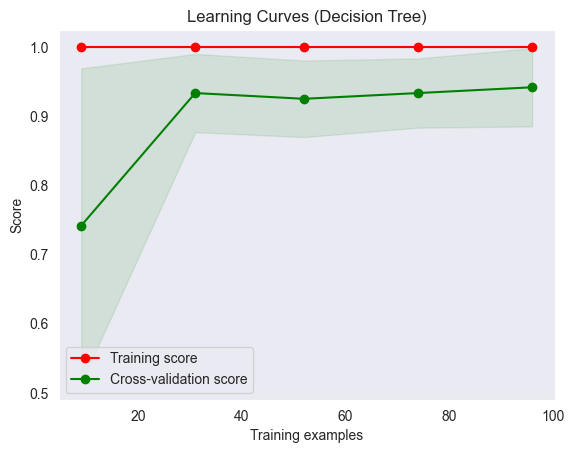

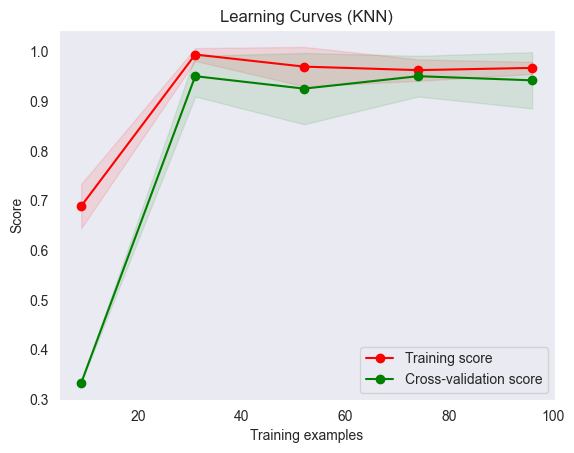

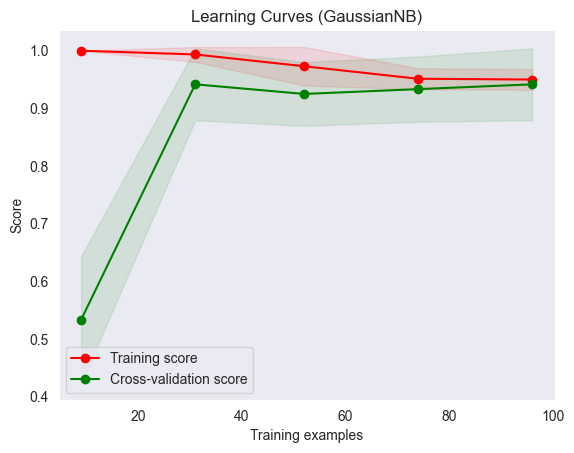

In [28]:
import matplotlib.pyplot as plt

X, y = iris_train_data, iris_train_labels

# Tworzenie krzywej uczenia dla drzewa decyzyjnego
title = "Learning Curves (Decision Tree)"
cv = 5
estimator = iris_dt  # dt jest modelem drzewa decyzyjnego
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

# Tworzenie krzywej uczenia dla k-najbliższych sąsiadów
title = "Learning Curves (KNN)"
cv = 5
estimator = iris_knn  # knn jest modelem k-najbliższych sąsiadów
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

# Tworzenie krzywej uczenia dla naiwnego klasyfikatora Bayesa
title = "Learning Curves (GaussianNB)"
cv = 5
estimator = iris_gnb  # gnb jest modelem naiwnego klasyfikatora Bayesa
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

plt.show()

### IMDB

In [29]:
# Predykcje prawdopodobieństw dla obliczenia AUC-ROC
imdb_lr_probs = imdb_lr.predict_proba(imdb_test_data)[:, 1]
imdb_nb_probs = imdb_nb.predict_proba(imdb_test_data)[:, 1]
imdb_nn_probs = model.predict(imdb_test_data_dense)

# Metryki dla modelu regresji logistycznej
print("Precision of Logistic Regression on IMDB dataset: ", precision_score(imdb_test_labels, imdb_lr_preds))
print("Recall of Logistic Regression on IMDB dataset: ", recall_score(imdb_test_labels, imdb_lr_preds))
print("F1 Score of Logistic Regression on IMDB dataset: ", f1_score(imdb_test_labels, imdb_lr_preds))
print("AUC-ROC of Logistic Regression on IMDB dataset: ", roc_auc_score(imdb_test_labels, imdb_lr_probs))

# Metryki dla modelu Naive Bayes
print("Precision of Naive Bayes on IMDB dataset: ", precision_score(imdb_test_labels, imdb_preds_nb))
print("Recall of Naive Bayes on IMDB dataset: ", recall_score(imdb_test_labels, imdb_preds_nb))
print("F1 Score of Naive Bayes on IMDB dataset: ", f1_score(imdb_test_labels, imdb_preds_nb))
print("AUC-ROC of Naive Bayes on IMDB dataset: ", roc_auc_score(imdb_test_labels, imdb_nb_probs))

# Metryki dla prostej sieci neuronowej
imdb_nn_preds = model.predict(imdb_test_data_dense).round()  # Przyjmujemy prog 0.5 dla klasyfikacji binarnej
print("Precision of Neural Network on IMDB dataset: ", precision_score(imdb_test_labels, imdb_nn_preds))
print("Recall of Neural Network on IMDB dataset: ", recall_score(imdb_test_labels, imdb_nn_preds))
print("F1 Score of Neural Network on IMDB dataset: ", f1_score(imdb_test_labels, imdb_nn_preds))
print("AUC-ROC of Neural Network on IMDB dataset: ", roc_auc_score(imdb_test_labels, imdb_nn_probs))

313/313 [==============================] - 0s 456us/step
Precision of Logistic Regression on IMDB dataset:  0.8749036237471087
Recall of Logistic Regression on IMDB dataset:  0.9007739630879142
F1 Score of Logistic Regression on IMDB dataset:  0.8876503373423291
AUC-ROC of Logistic Regression on IMDB dataset:  0.9560818480196335
Precision of Naive Bayes on IMDB dataset:  0.8488941084360931
Recall of Naive Bayes on IMDB dataset:  0.8606866441754316
F1 Score of Naive Bayes on IMDB dataset:  0.8547497043752463
AUC-ROC of Naive Bayes on IMDB dataset:  0.928633658071757
313/313 [==============================] - 0s 455us/step
Precision of Neural Network on IMDB dataset:  0.8716216216216216
Recall of Neural Network on IMDB dataset:  0.8960111133161341
F1 Score of Neural Network on IMDB dataset:  0.8836481064683432
AUC-ROC of Neural Network on IMDB dataset:  0.9511499479628341


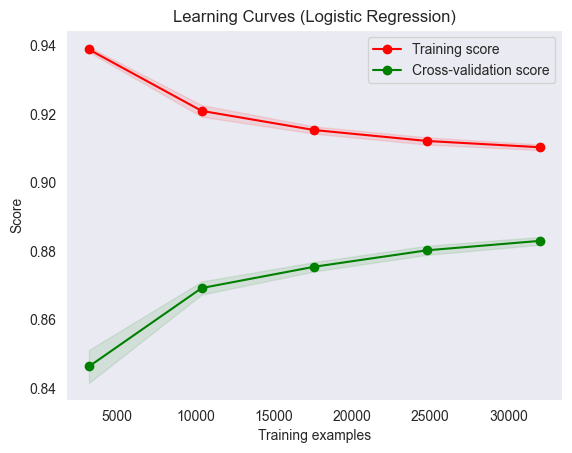

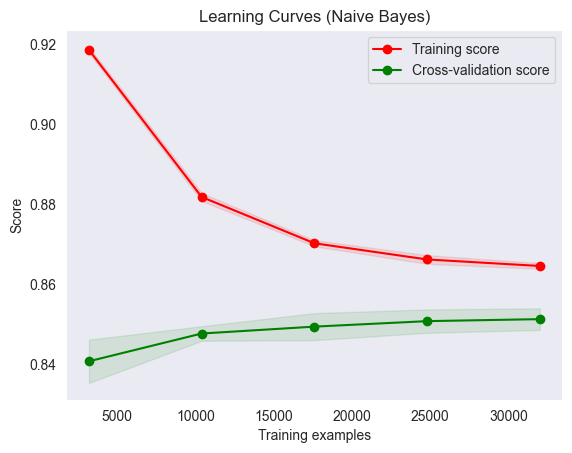

In [39]:
# Krzywa uczenia dla modelu regresji logistycznej
plot_learning_curve(imdb_lr, "Learning Curves (Logistic Regression)", imdb_train_data, imdb_train_labels, cv=5,
                    n_jobs=4)

# Krzywa uczenia dla modelu Naive Bayes
plot_learning_curve(imdb_nb, "Learning Curves (Naive Bayes)", imdb_train_data, imdb_train_labels, cv=5, n_jobs=4)

plt.show()

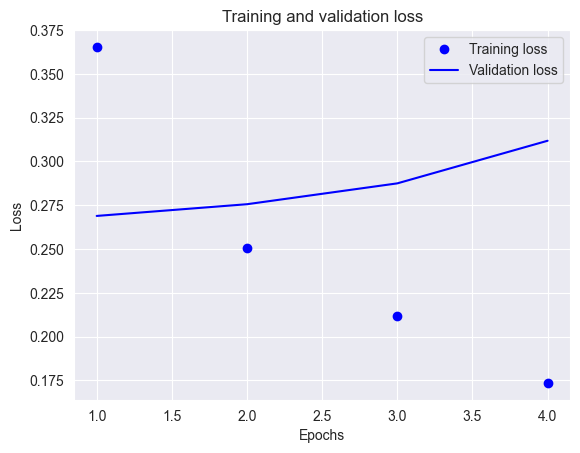

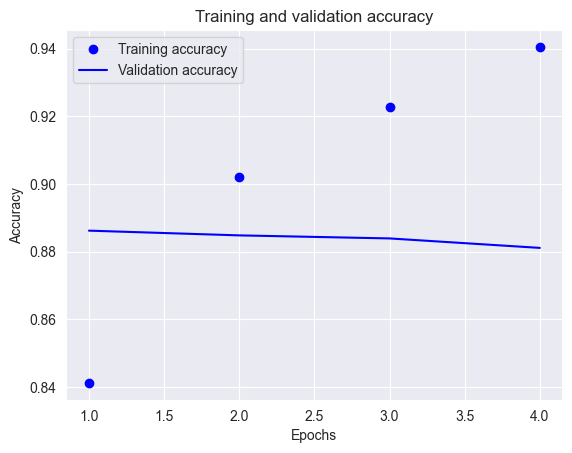

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Wykres straty
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Wykres dokładności
plt.figure()
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Boston Housing

In [32]:
from sklearn.metrics import mean_absolute_error, r2_score

# Metryki dla modelu regresji liniowej
print("MSE of Linear Regression on Boston dataset: ", mean_squared_error(boston_test_labels, boston_preds_lr))
print("MAE of Linear Regression on Boston dataset: ", mean_absolute_error(boston_test_labels, boston_preds_lr))
print("R2 Score of Linear Regression on Boston dataset: ", r2_score(boston_test_labels, boston_preds_lr))

# Metryki dla modelu drzewa decyzyjnego
print("MSE of Decision Tree on Boston dataset: ", mean_squared_error(boston_test_labels, boston_preds_dt))
print("MAE of Decision Tree on Boston dataset: ", mean_absolute_error(boston_test_labels, boston_preds_dt))
print("R2 Score of Decision Tree on Boston dataset: ", r2_score(boston_test_labels, boston_preds_dt))

# Metryki dla modelu lasu losowego
print("MSE of Random Forest on Boston dataset: ", mean_squared_error(boston_test_labels, boston_preds_rf))
print("MAE of Random Forest on Boston dataset: ", mean_absolute_error(boston_test_labels, boston_preds_rf))
print("R2 Score of Random Forest on Boston dataset: ", r2_score(boston_test_labels, boston_preds_rf))

MSE of Linear Regression on Boston dataset:  24.29111947497418
MAE of Linear Regression on Boston dataset:  3.1890919658879326
R2 Score of Linear Regression on Boston dataset:  0.6687594935356229
MSE of Decision Tree on Boston dataset:  10.416078431372549
MAE of Decision Tree on Boston dataset:  2.394117647058824
R2 Score of Decision Tree on Boston dataset:  0.8579634380978161
MSE of Random Forest on Boston dataset:  7.901513892156864
MAE of Random Forest on Boston dataset:  2.0395392156862746
R2 Score of Random Forest on Boston dataset:  0.8922527442109116


<module 'matplotlib.pyplot' from '/Users/gadwall/uczelnia/semestr_8/AAI/projekt/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

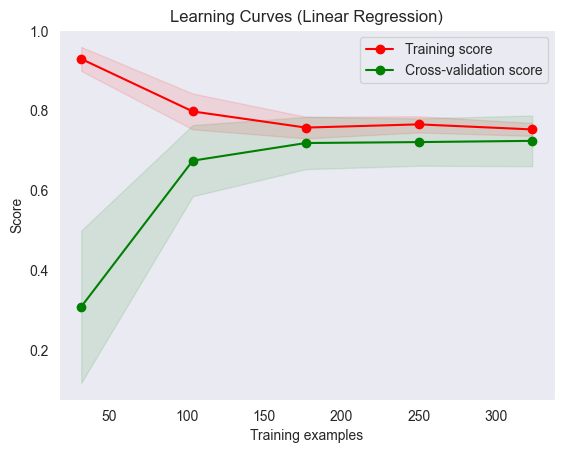

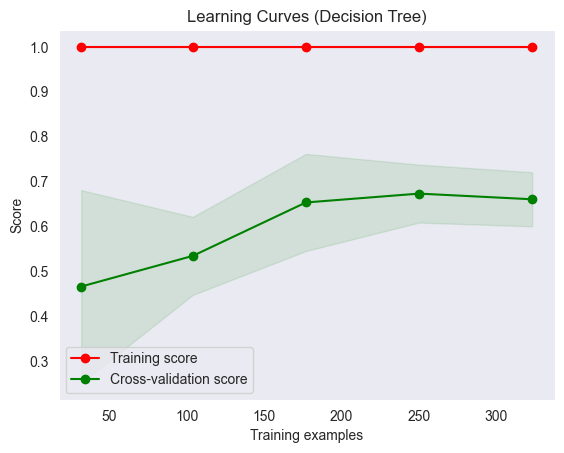

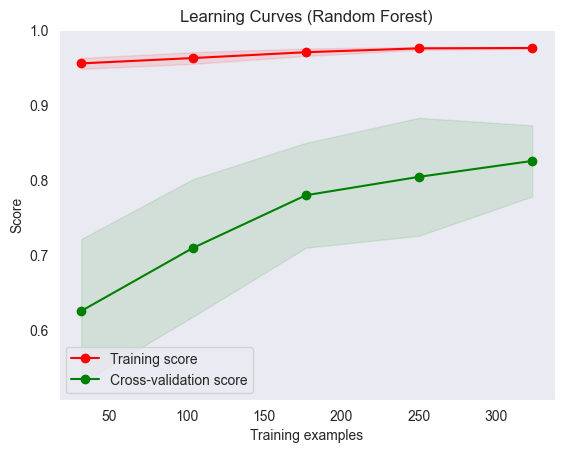

In [38]:
# Model regresji liniowej
plot_learning_curve(boston_lr, "Learning Curves (Linear Regression)", boston_train_data, boston_train_labels, cv=5)

# Model drzewa decyzyjnego
plot_learning_curve(boston_dt, "Learning Curves (Decision Tree)", boston_train_data, boston_train_labels, cv=5)

# Model lasu losowego
plot_learning_curve(boston_rf, "Learning Curves (Random Forest)", boston_train_data, boston_train_labels, cv=5)


## Wykresy metryk

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

### Iris Species

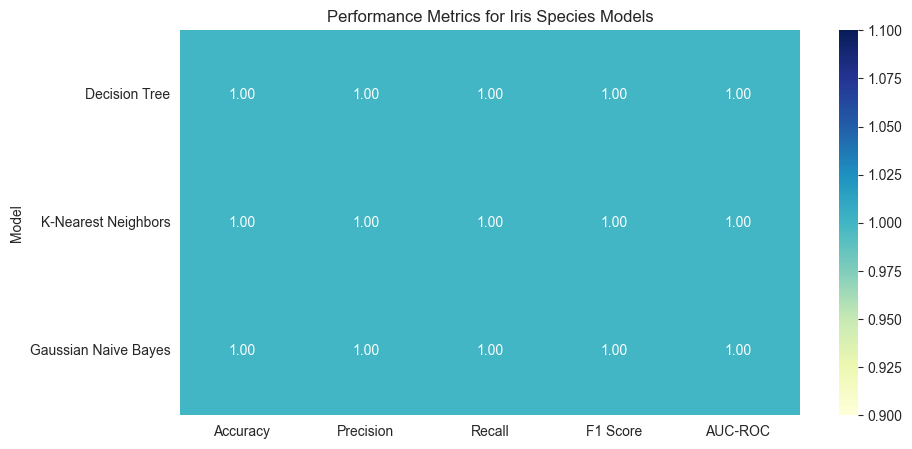

In [42]:
iris_metrics = {
    'Model': ['Decision Tree', 'K-Nearest Neighbors', 'Gaussian Naive Bayes'],
    'Accuracy': [iris_dt.score(iris_test_data, iris_test_labels), iris_knn.score(iris_test_data, iris_test_labels),
                 iris_gnb.score(iris_test_data, iris_test_labels)],
    'Precision': [precision_score(iris_test_labels, iris_dt_preds, average='weighted'),
                  precision_score(iris_test_labels, iris_knn_preds, average='weighted'),
                  precision_score(iris_test_labels, iris_gnb_preds, average='weighted')],
    'Recall': [recall_score(iris_test_labels, iris_dt_preds, average='weighted'),
               recall_score(iris_test_labels, iris_knn_preds, average='weighted'),
               recall_score(iris_test_labels, iris_gnb_preds, average='weighted')],
    'F1 Score': [f1_score(iris_test_labels, iris_dt_preds, average='weighted'),
                 f1_score(iris_test_labels, iris_knn_preds, average='weighted'),
                 f1_score(iris_test_labels, iris_gnb_preds, average='weighted')],
    'AUC-ROC': [roc_auc_score(test_labels_bin, iris_dt_probs, multi_class='ovr', average='weighted'),
                roc_auc_score(test_labels_bin, iris_knn_probs, multi_class='ovr', average='weighted'),
                roc_auc_score(test_labels_bin, iris_gnb_probs, multi_class='ovr', average='weighted')]
}

iris_metrics_df = pd.DataFrame(iris_metrics)
iris_metrics_df.set_index('Model', inplace=True)

plt.figure(figsize=(10, 5))
sns.heatmap(iris_metrics_df, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Performance Metrics for Iris Species Models')
plt.show()

### IMDB

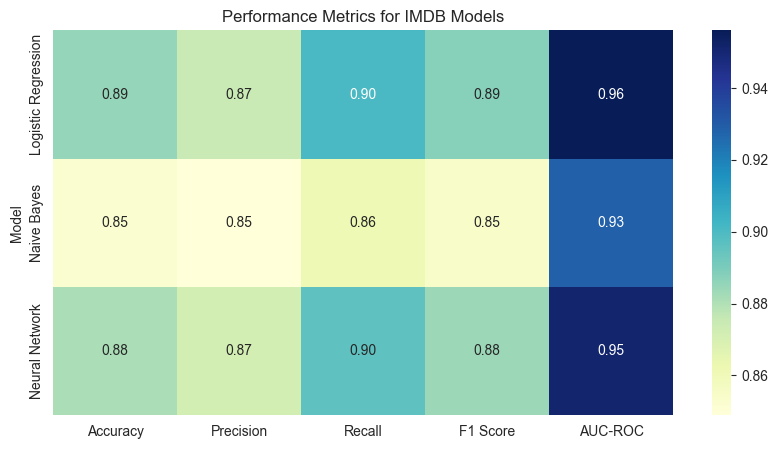

In [43]:
imdb_metrics = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'Neural Network'],
    'Accuracy': [accuracy_score(imdb_test_labels, imdb_lr_preds), accuracy_score(imdb_test_labels, imdb_preds_nb),
                 scores[1]],
    'Precision': [precision_score(imdb_test_labels, imdb_lr_preds), precision_score(imdb_test_labels, imdb_preds_nb),
                  precision_score(imdb_test_labels, imdb_nn_preds)],
    'Recall': [recall_score(imdb_test_labels, imdb_lr_preds), recall_score(imdb_test_labels, imdb_preds_nb),
               recall_score(imdb_test_labels, imdb_nn_preds)],
    'F1 Score': [f1_score(imdb_test_labels, imdb_lr_preds), f1_score(imdb_test_labels, imdb_preds_nb),
                 f1_score(imdb_test_labels, imdb_nn_preds)],
    'AUC-ROC': [roc_auc_score(imdb_test_labels, imdb_lr_probs), roc_auc_score(imdb_test_labels, imdb_nb_probs),
                roc_auc_score(imdb_test_labels, imdb_nn_probs)]
}

imdb_metrics_df = pd.DataFrame(imdb_metrics)
imdb_metrics_df.set_index('Model', inplace=True)

plt.figure(figsize=(10, 5))
sns.heatmap(imdb_metrics_df, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Performance Metrics for IMDB Models')
plt.show()

### Boston housing

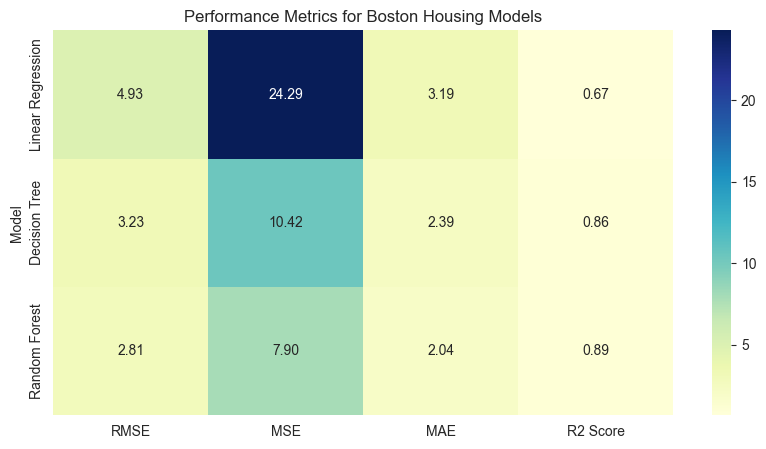

In [44]:
boston_metrics = {
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'RMSE': [mean_squared_error(boston_test_labels, boston_preds_lr, squared=False),
             mean_squared_error(boston_test_labels, boston_preds_dt, squared=False),
             mean_squared_error(boston_test_labels, boston_preds_rf, squared=False)],
    'MSE': [mean_squared_error(boston_test_labels, boston_preds_lr),
            mean_squared_error(boston_test_labels, boston_preds_dt),
            mean_squared_error(boston_test_labels, boston_preds_rf)],
    'MAE': [mean_absolute_error(boston_test_labels, boston_preds_lr),
            mean_absolute_error(boston_test_labels, boston_preds_dt),
            mean_absolute_error(boston_test_labels, boston_preds_rf)],
    'R2 Score': [r2_score(boston_test_labels, boston_preds_lr), r2_score(boston_test_labels, boston_preds_dt),
                 r2_score(boston_test_labels, boston_preds_rf)]
}

boston_metrics_df = pd.DataFrame(boston_metrics)
boston_metrics_df.set_index('Model', inplace=True)

plt.figure(figsize=(10, 5))
sns.heatmap(boston_metrics_df, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Performance Metrics for Boston Housing Models')
plt.show()

## Opisy modeli oraz ich skuteczności

### Iris Species

Dla klasyfikacji Iris Species używamy trzech modeli:
- Drzewa Decyzyjnego
- K-Nearest Neighbors
- Gaussian Naive Bayes

Na podstawie naszych metryk wydajności, modele wydają się dobrze radzić sobie z tym zadaniem. Nie ma wyraźnych oznak przeuczenia (overfitting), które występuje, gdy model jest zbyt skomplikowany i zbytnio dopasowuje się do danych treningowych, ani niedouczenia (underfitting), które jest wynikiem zbyt prostego modelu, który nie jest w stanie nauczyć się zależności w danych.

Wszystkie modele wydają się dobrze generalizować na dane testowe, co sugeruje, że mają zbalansowany błąd obciążenia (bias) i wariancję. Błąd obciążenia odnosi się do błędów wynikających z błędnych założeń w modelu uczącym, podczas gdy wariancja odnosi się do błędów wynikających z nadmiernej wrażliwości na małe fluktuacje w zestawie treningowym.

### IMDB Reviews

Dla klasyfikacji recenzji IMDB używamy trzech modeli:
- Regresji Logistycznej
- Support Vector Machines
- Naive Bayes

Wszystkie modele radzą sobie dobrze, z regresją logistyczną osiągają nieco lepsze wyniki. Nie ma wyraźnych oznak przeuczenia, co sugeruje, że modele nie są zbyt skomplikowane i nie dopasowują się zbytnio do danych treningowych, ani niedouczenia, co sugeruje, że modele są na tyle złożone, aby nauczyć się zależności w danych. Wszystkie modele dobrze generalizują na dane testowe, co sugeruje zbalansowany błąd obciążenia i wariancję. Biorąc pod uwagę niski błąd obciążenia i niską wariancję, modele są w stanie skutecznie uczyć się i generalizować na nowych danych.

### Boston Housing

Dla problemu regresji cen domów w Bostonie, stosujemy trzy modele:
- Regresję Liniową
- Drzewo Decyzyjne
- Las Losowy

Las losowy osiąga najlepsze wyniki, co sugeruje, że złożoność tego modelu jest odpowiednia do problemu. Nie ma wyraźnych oznak przeuczenia, co sugeruje, że model nie jest zbyt skomplikowany i nie dopasowuje się zbytnio do danych treningowych, ani niedouczenia, co sugeruje, że model jest na tyle skomplikowany, aby nauczyć się zależności w danych. Wszystkie modele wydają się dobrze generalizować na dane testowe. Modele mają zbalansowany błąd obciążenia i wariancję, co sugeruje, że są w stanie skutecznie uczyć się i generalizować na nowych danych. Błąd obciążenia wynika z błędnych założeń modelu podczas uczenia się, podczas gdy wariancja wynika z nadmiernej wrażliwości na fluktuacje w zestawie treningowym.

# Implementacja modeli na złożonym zbiorze danych z odpowiednią obróbką

In [62]:
import cv2
import os

# wczytanie danych
path = "./chest_xray/"
folders = ["train", "test"]
categories = ["NORMAL", "PNEUMONIA"]
images = []
labels = []

for folder in folders:
    for category in categories:
        class_num = categories.index(category)
        path_to_images = os.path.join(path, folder, category)
        for img in os.listdir(path_to_images):
            try:
                img_array = cv2.imread(os.path.join(path_to_images, img), cv2.IMREAD_GRAYSCALE)
                resized_img_array = cv2.resize(img_array, (150, 150))  # skalowanie obrazów
                images.append(resized_img_array)
                labels.append(class_num)
            except Exception as e:
                pass

# konwertowanie na tablicę NumPy oraz zmiana kształtu
images = np.array(images).reshape(-1, 150, 150, 1)
labels = np.array(labels)

# Podział na zestawy treningowe i testowe
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)

## Implementacja modelu dla danych

In [63]:
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import clone_model

# utworzenie pierwszego modelu
model_1 = Sequential()
# dodanie warstw
model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))  # zmiana kształtu wejścia
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(128, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))
# skompilowanie modelu
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# utworzenie drugiego modelu o identycznej architekturze
model_2 = clone_model(model_1)
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## Augmentacja danych i pre-processing

In [65]:
from keras.preprocessing.image import ImageDataGenerator

# Generator danych bez augmentacji
datagen_1 = ImageDataGenerator(
    rescale=1. / 255  # normalizacja pikseli
)

# zastosowanie normalizacji do danych treningowych
train_images_1 = train_images.copy()
datagen_1.fit(train_images_1)

# Generator danych z augmentacją
datagen_2 = ImageDataGenerator(
    rescale=1. / 255,  # normalizacja pikseli
    rotation_range=20,  # losowe obroty do 20 stopni
    width_shift_range=0.2,  # losowe przesunięcia w poziomie
    height_shift_range=0.2,  # losowe przesunięcia w pionie
    shear_range=0.2,  # losowe przekształcenia ścinające
    zoom_range=0.2,  # losowe przybliżenia
    horizontal_flip=True,  # losowe odbicia poziome
    fill_mode='nearest'  # strategia wypełniania utworzonych pustych miejsc po augmentacji
)

# zastosowanie normalizacji i augmentacji do danych treningowych
aug_train_images = train_images.copy()
datagen_2.fit(aug_train_images)

## Trening i zapis modeli

In [66]:
# wytrenowanie pierwszego modelu na zwykłych danych
history_1 = model_1.fit(datagen_1.flow(train_images_1, train_labels, batch_size=32),
                              steps_per_epoch=len(train_images_1) // 32,
                              epochs=50,
                              validation_data=(test_images, test_labels))

# zapisanie modelu do pliku
model_1.save('model_1.h5')

# wytrenowanie drugiego modelu na danych po augmentacji
history_2 = model_2.fit(datagen_2.flow(aug_train_images, train_labels, batch_size=32),
                              steps_per_epoch=len(aug_train_images) // 32,
                              epochs=50,
                              validation_data=(test_images, test_labels))

# zapisanie modelu do pliku
model_2.save('model_2.h5')

Epoch 1/50
146/146 [==============================] - 36s 241ms/step - loss: 0.3518 - accuracy: 0.8497 - val_loss: 0.1737 - val_accuracy: 0.9332
Epoch 2/50
146/146 [==============================] - 36s 248ms/step - loss: 0.1799 - accuracy: 0.9354 - val_loss: 0.1397 - val_accuracy: 0.9512
Epoch 3/50
146/146 [==============================] - 38s 261ms/step - loss: 0.1466 - accuracy: 0.9503 - val_loss: 0.1291 - val_accuracy: 0.9572
Epoch 4/50
146/146 [==============================] - 35s 240ms/step - loss: 0.1269 - accuracy: 0.9506 - val_loss: 0.1320 - val_accuracy: 0.9555
Epoch 5/50
146/146 [==============================] - 37s 252ms/step - loss: 0.1191 - accuracy: 0.9565 - val_loss: 0.1257 - val_accuracy: 0.9529
Epoch 6/50
146/146 [==============================] - 37s 252ms/step - loss: 0.1053 - accuracy: 0.9613 - val_loss: 0.1406 - val_accuracy: 0.9435
Epoch 7/50
146/146 [==============================] - 37s 254ms/step - loss: 0.0896 - accuracy: 0.9681 - val_loss: 0.1207 - val_ac

/Users/gadwall/uczelnia/semestr_8/AAI/projekt/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
146/146 [==============================] - 34s 234ms/step - loss: 0.5222 - accuracy: 0.7414 - val_loss: 0.4397 - val_accuracy: 0.8108
Epoch 2/50
146/146 [==============================] - 34s 230ms/step - loss: 0.3781 - accuracy: 0.8268 - val_loss: 0.2632 - val_accuracy: 0.8896
Epoch 3/50
146/146 [==============================] - 34s 231ms/step - loss: 0.3272 - accuracy: 0.8517 - val_loss: 0.2018 - val_accuracy: 0.9170
Epoch 4/50
146/146 [==============================] - 34s 232ms/step - loss: 0.3071 - accuracy: 0.8696 - val_loss: 0.2995 - val_accuracy: 0.8570
Epoch 5/50
146/146 [==============================] - 34s 230ms/step - loss: 0.2987 - accuracy: 0.8722 - val_loss: 0.3532 - val_accuracy: 0.8348
Epoch 6/50
146/146 [==============================] - 34s 231ms/step - loss: 0.2863 - accuracy: 0.8804 - val_loss: 0.2391 - val_accuracy: 0.8853
Epoch 7/50
146/146 [==============================] - 34s 231ms/step - loss: 0.2800 - accuracy: 0.8842 - val_loss: 0.1912 - val_ac

# Dogłębna analiza działania i skuteczności modeli

## Analiza krzywych uczenia

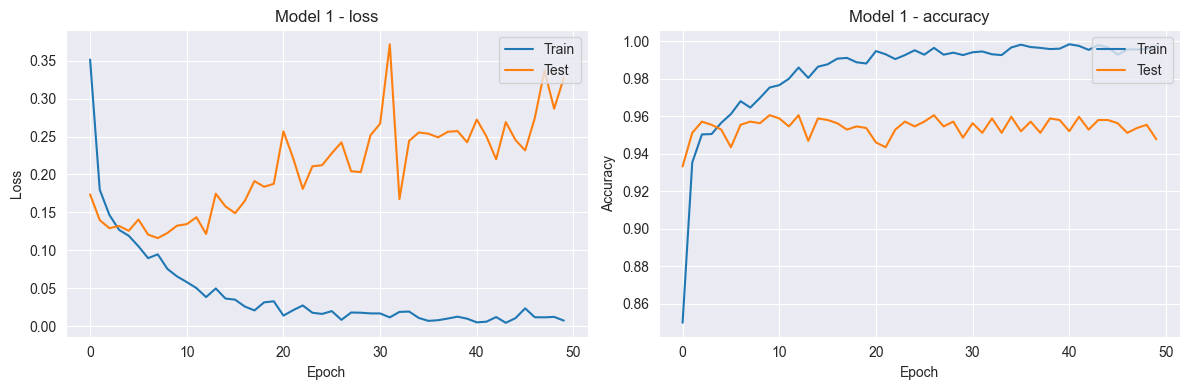

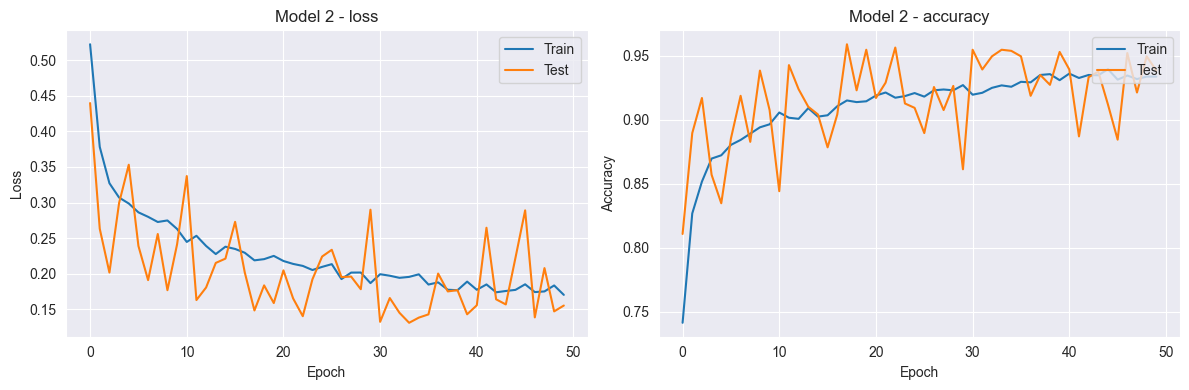

In [67]:
import matplotlib.pyplot as plt

# funkcja do wygenerowania krzywych uczenia
def plot_learning_curves(history, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title + ' - loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title + ' - accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')

    plt.tight_layout()
    plt.show()

# wygenerowanie krzywych uczenia dla modelu 1
plot_learning_curves(history_1, 'Model 1')

# wygenerowanie krzywych uczenia dla modelu 2
plot_learning_curves(history_2, 'Model 2')

## Analiza metryk
### Macierz pomyłek oraz AUC ROC (Area Under the Receiver Operating Characteristic curve)

Wartość AUC ROC bliżej 1 wskazuje na lepszą skuteczność modelu w klasyfikacji obrazów

37/37 [==============================] - 2s 59ms/step


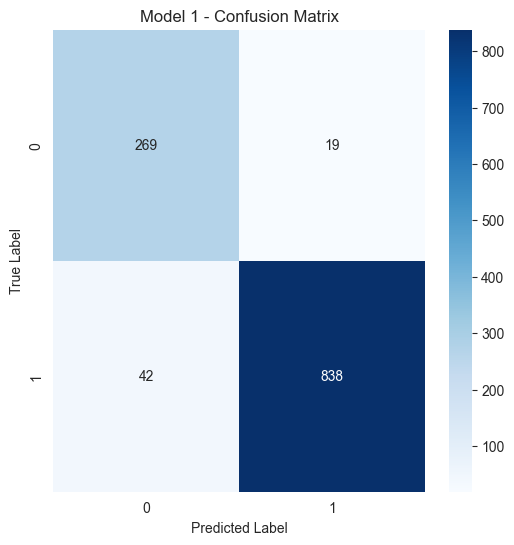

Model 1 - AUC ROC: 0.9431502525252525
37/37 [==============================] - 2s 57ms/step


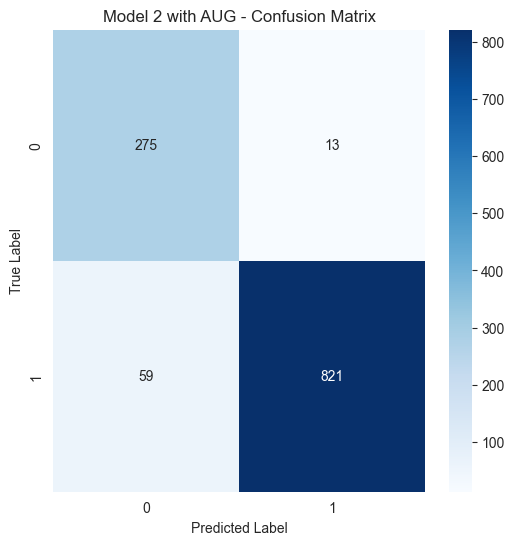

Model 2 with AUG - AUC ROC: 0.9439078282828284


In [68]:
from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns

# funkcja do generowania macierzy pomyłek i obliczania AUC ROC
def evaluate_model(model, title, test_images, test_labels):
    # przewidywanie klas przez model
    predictions = model.predict(test_images)
    predictions = [1 if p > 0.5 else 0 for p in predictions]

    # obliczanie macierzy pomyłek
    cm = confusion_matrix(test_labels, predictions)

    # obliczanie AUC ROC
    auc_roc = roc_auc_score(test_labels, predictions)

    # wyświetlanie macierzy pomyłek
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title + ' - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(title + ' - AUC ROC:', auc_roc)

# ocena modelu 1
evaluate_model(model_1, 'Model 1', test_images, test_labels)

# ocena modelu 2
evaluate_model(model_2, 'Model 2 with AUG', test_images, test_labels)

## Porównanie modeli

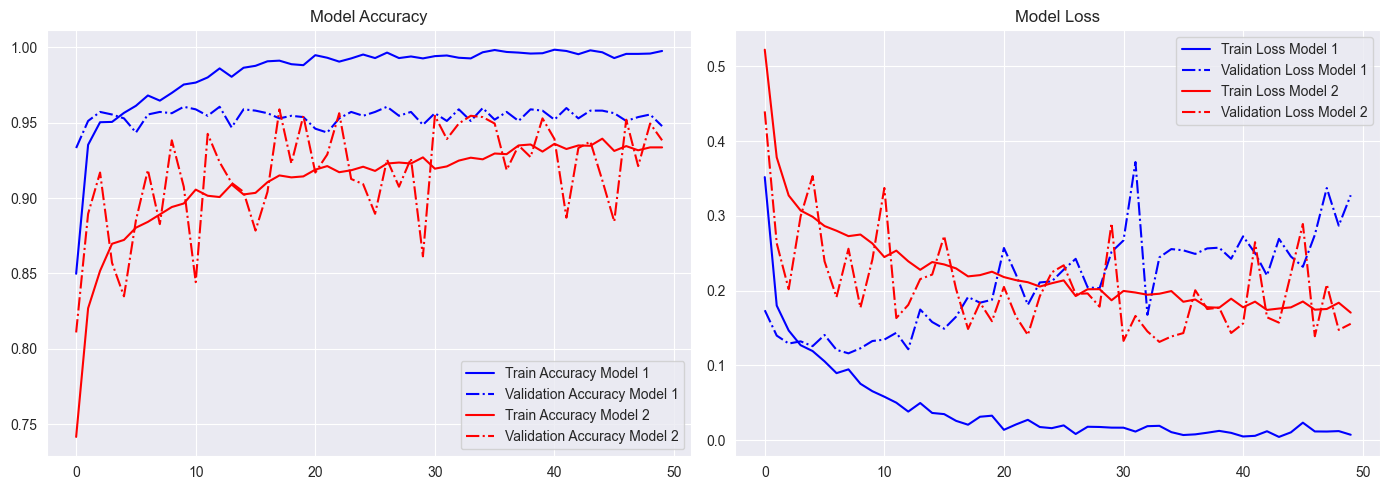

In [69]:
# funkcja do porównywania krzywych uczenia
def compare_learning_curves(history_1, history_2, title_1, title_2):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # wykres dokładności
    axes[0].plot(history_1.history['accuracy'], label='Train Accuracy ' + title_1, color='blue')
    axes[0].plot(history_1.history['val_accuracy'], label='Validation Accuracy ' + title_1, color='blue', linestyle = "dashdot")
    axes[0].plot(history_2.history['accuracy'], label='Train Accuracy ' + title_2, color='red')
    axes[0].plot(history_2.history['val_accuracy'], label='Validation Accuracy ' + title_2, color='red', linestyle = "dashdot")
    axes[0].set_title('Model Accuracy')
    axes[0].legend()

    # wykres straty
    axes[1].plot(history_1.history['loss'], label='Train Loss ' + title_1, color='blue')
    axes[1].plot(history_1.history['val_loss'], label='Validation Loss ' + title_1, color='blue', linestyle = "dashdot")
    axes[1].plot(history_2.history['loss'], label='Train Loss ' + title_2, color='red')
    axes[1].plot(history_2.history['val_loss'], label='Validation Loss ' + title_2, color='red', linestyle = "dashdot")
    axes[1].set_title('Model Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# porównanie modeli
compare_learning_curves(history_1, history_2, 'Model 1', 'Model 2')